In [1]:
import os

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import chex
from optax import contrib

In [3]:
# adversarial step
# params = params + sam_rho * normalize(gradient)

# outer update step
# params = cache - learning_rate * gradient
# cache = params

In [4]:
lr = 0.01
rho = 0.1
opt = optax.sgd(lr)
adv_opt = optax.chain(contrib.normalize(), optax.sgd(rho))
sam_opt = contrib.sam(opt, adv_opt, sync_period=2)

sgd_opt = optax.sgd(lr)

In [5]:
def sam_mom(lr=1e-3, momentum=0.1, rho=0.1, sync_period=2):
  opt = optax.sgd(lr, momentum=momentum)
  adv_opt = optax.chain(contrib.normalize(), optax.sgd(rho))
  return contrib.sam(opt, adv_opt, sync_period=sync_period)

mom = 0.9
sam_mom_opt = sam_mom(lr, momentum=mom)
mom_opt = optax.sgd(lr, momentum=mom)

In [6]:
def sam_adam(lr=1e-3, b1=0.9, b2=0.999, rho=0.03, sync_period=5):
  """A SAM optimizer using Adam for the outer optimizer."""
  opt = optax.adam(lr, b1=b1, b2=b2)
  adv_opt = optax.chain(contrib.normalize(), optax.adam(rho))
  return contrib.sam(opt, adv_opt, sync_period=sync_period)

sam_adam_opt = sam_adam(lr)
adam_opt = optax.adam(lr)

2024-11-28 16:22:09.359913: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.68). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


<Figure size 1920x1440 with 0 Axes>

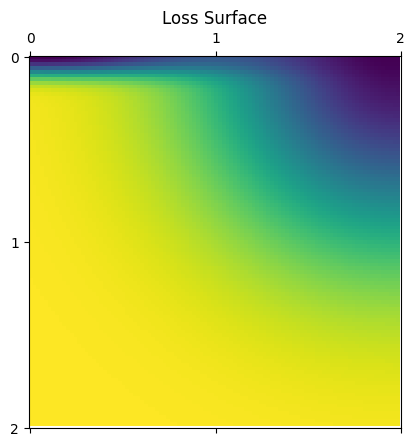

In [7]:
# An example 2D loss function. It has two minima at (0,0) and (2,0).
# Both points attain almost zero loss value, but the first one is much sharper.

def loss(params):
  x, y = params
  return -jnp.exp(-(x - 2)**2 - y**2) - 1.0*jnp.exp(-((x)**2 + (y)**2*100))

x, y = jnp.meshgrid(jnp.linspace(0, 2, 100), jnp.linspace(0, 2, 100))
l = loss((x, y))

fig = plt.figure(dpi=300)
plt.matshow(l)
plt.xticks([0, 50, 100], [0, 1, 2])
plt.yticks([0, 50, 100], [0, 1, 2])
plt.title('Loss Surface')
plt.show()

In [8]:
params = jnp.array([-0.4, -0.4])

@chex.dataclass
class Store:
    params: chex.Array
    state: optax.OptState
    step: int = 0

sam_store = Store(params=params, state=sam_opt.init(params))
sgd_store = Store(params=params, state=sgd_opt.init(params))
sam_mom_store = Store(params=params, state=sam_mom_opt.init(params))
mom_store = Store(params=params, state=mom_opt.init(params))
sam_adam_store = Store(params=params, state=sam_adam_opt.init(params))
adam_store = Store(params=params, state=adam_opt.init(params))

In [9]:
def make_step(opt):
    @jax.jit
    def step(store):
        value, grads = jax.value_and_grad(loss)(store.params)
        updates, state = opt.update(grads, store.state, store.params)
        params = optax.apply_updates(store.params, updates)
        return store.replace(
            params = params,
            state = state,
            step = store.step + 1
        ), value
    return step

In [10]:
sam_step = make_step(sam_opt)
sgd_step = make_step(sgd_opt)

sam_mom_step = make_step(sam_mom_opt)
mom_step = make_step(mom_opt)

sam_adam_step = make_step(sam_adam_opt)
adam_step = make_step(adam_opt)

In [11]:
sam_vals = []
sam_params = []
sgd_vals = []
sgd_params = []

sam_mom_vals = []
sam_mom_params = []
mom_vals = []
mom_params = []

sam_adam_vals = []
sam_adam_params = []
adam_vals = []
adam_params = []

In [12]:
T = 8000
for i in range(T):
  sam_store, sam_val = sam_step(sam_store)
  sgd_store, sgd_val = sgd_step(sgd_store)
  sam_mom_store, sam_mom_val = sam_mom_step(sam_mom_store)
  mom_store, mom_val = mom_step(mom_store)
  sam_adam_store, sam_adam_val = sam_adam_step(sam_adam_store)
  adam_store, adam_val = adam_step(adam_store)

  sam_vals.append(sam_val)
  sgd_vals.append(sgd_val)
  sam_mom_vals.append(sam_mom_val)
  mom_vals.append(mom_val)
  sam_adam_vals.append(sam_adam_val)
  adam_vals.append(adam_val)

  sam_params.append(sam_store.params)
  sgd_params.append(sgd_store.params)
  sam_mom_params.append(sam_mom_store.params)
  mom_params.append(mom_store.params)
  sam_adam_params.append(sam_adam_store.params)
  adam_params.append(adam_store.params)

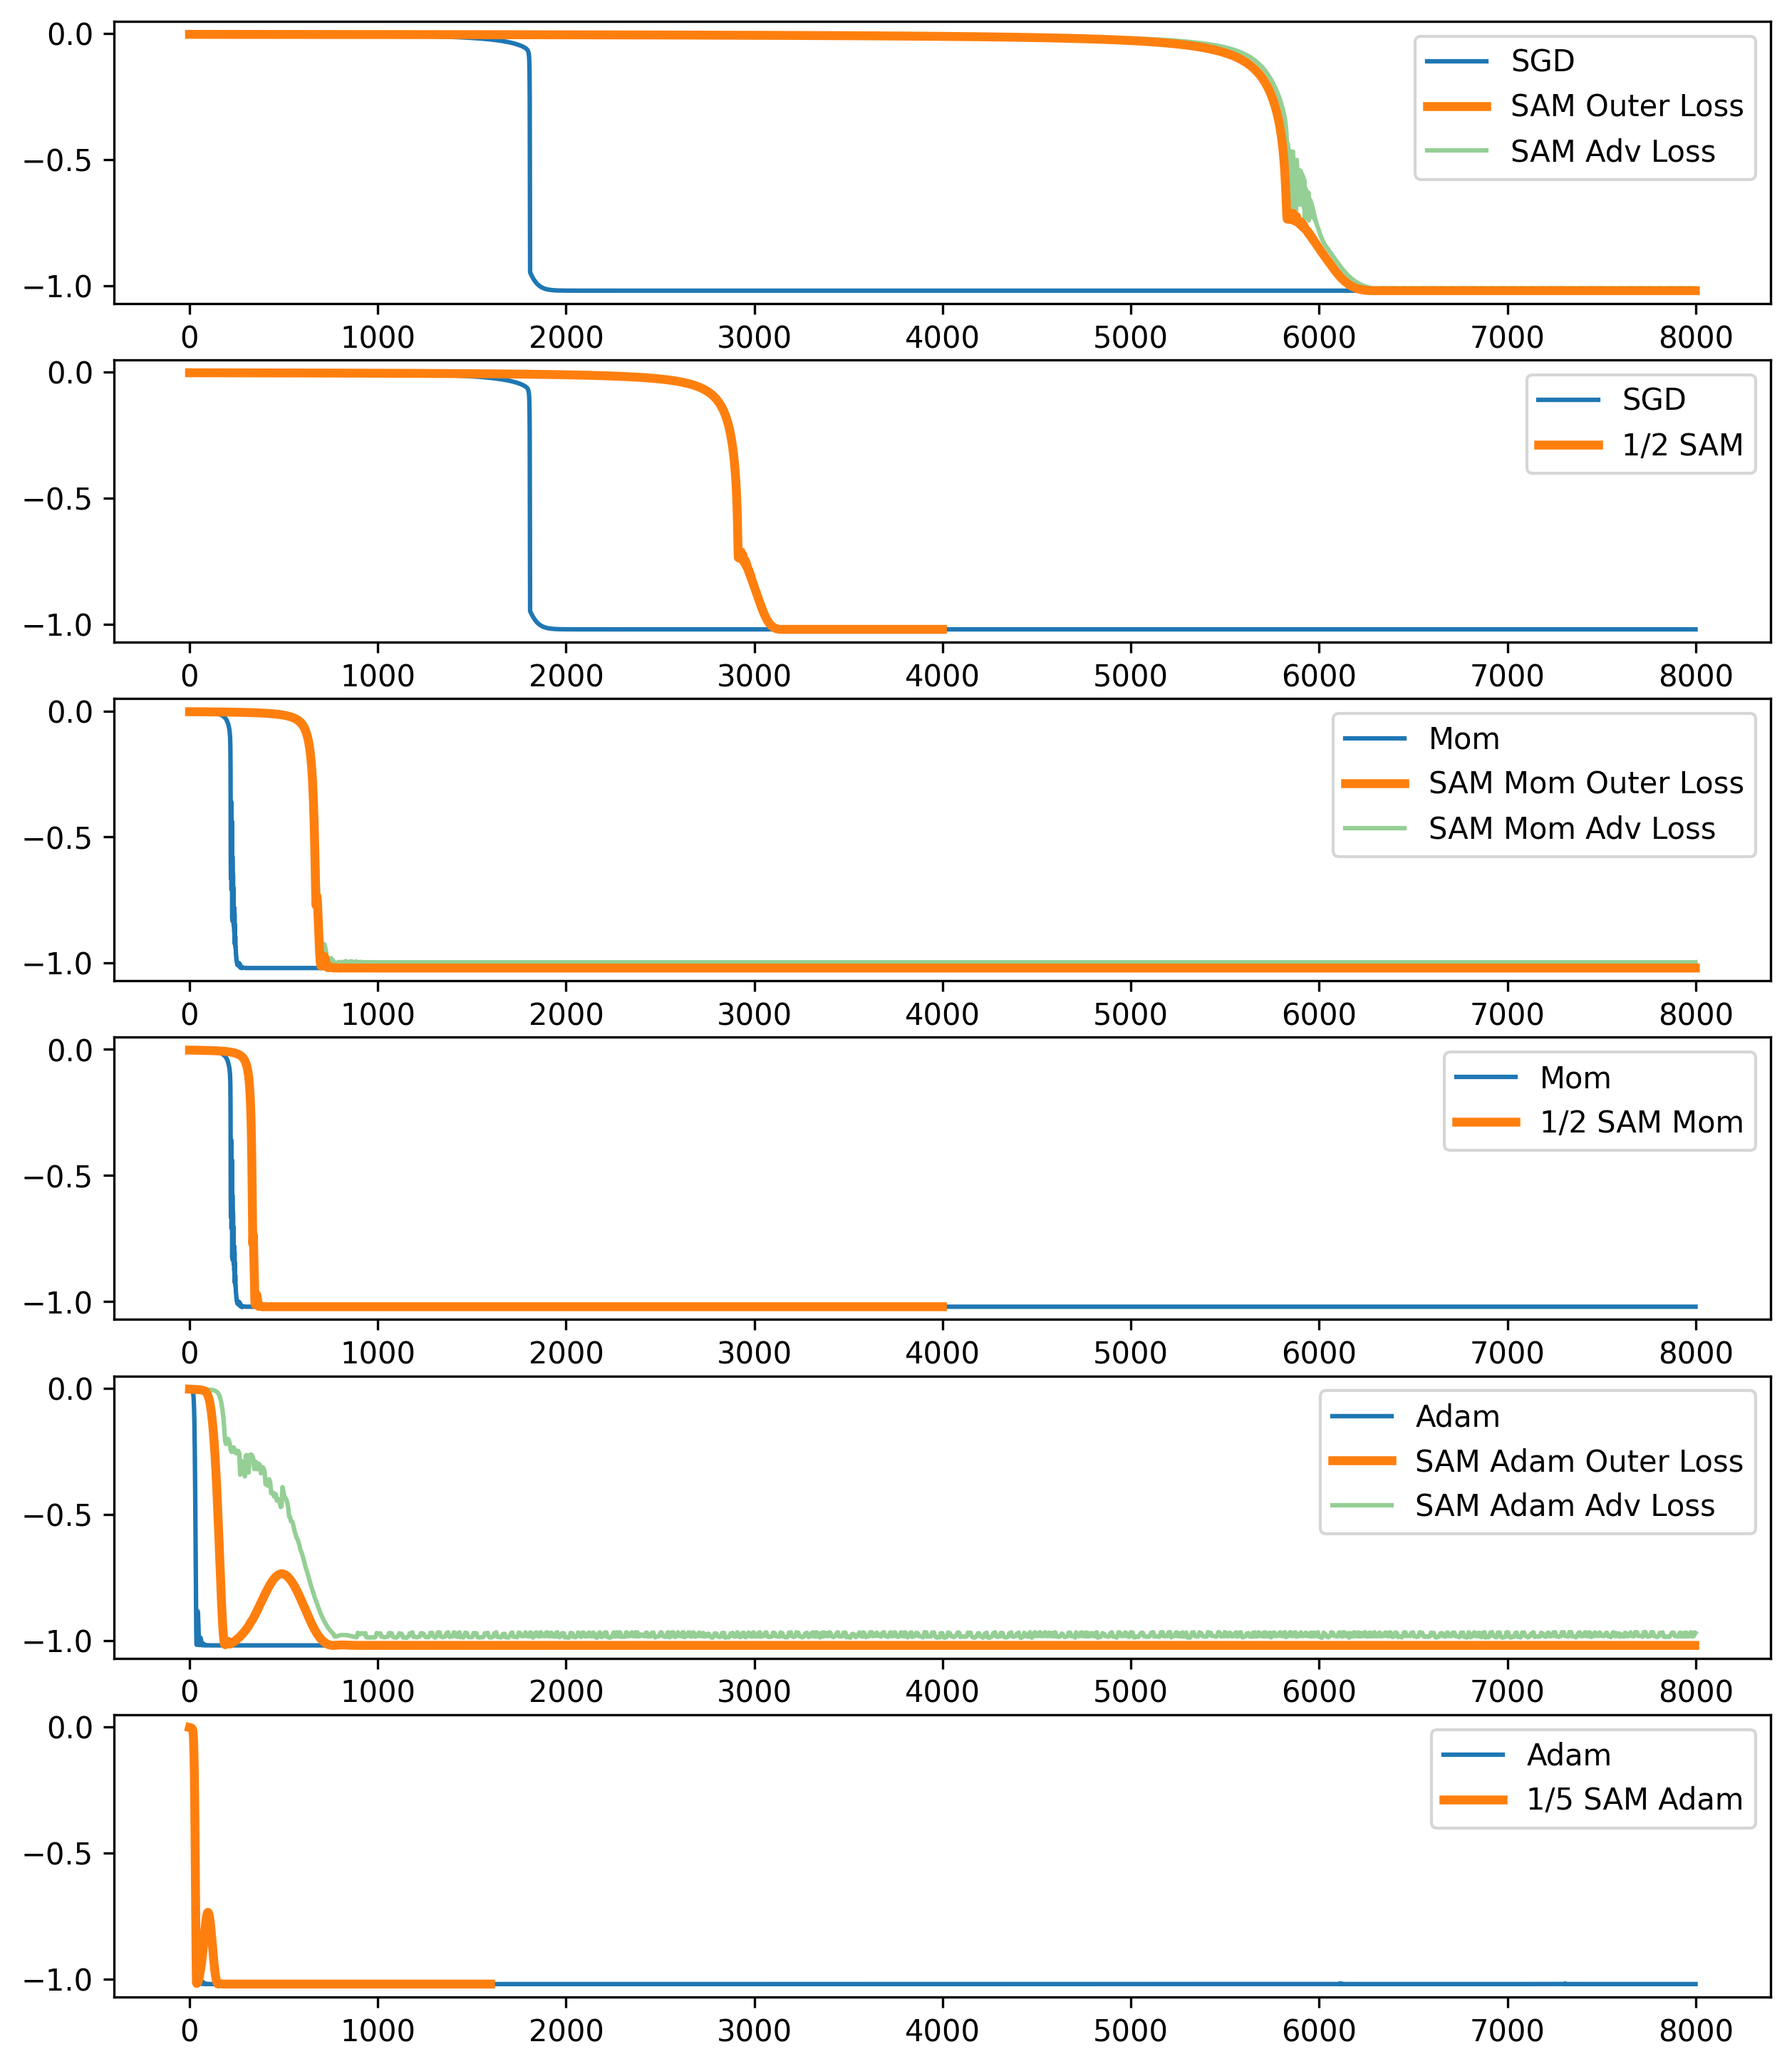

In [13]:
ts = jnp.arange(T)
fig, axs = plt.subplots(6, figsize=(10, 12), dpi=300)
axs[0].plot(ts, sgd_vals, label='SGD')
axs[0].plot(ts[::2], sam_vals[0::2], label='SAM Outer Loss', lw=3, zorder=100)
axs[0].plot(ts[1::2], sam_vals[1::2], label='SAM Adv Loss', alpha=0.5)
axs[0].legend();

axs[1].plot(ts, sgd_vals, label='SGD')
axs[1].plot(ts[::2] / 2, sam_vals[::2], label='1/2 SAM', lw=3)
axs[1].legend();

axs[2].plot(ts, mom_vals, label='Mom')
axs[2].plot(ts[::2], sam_mom_vals[::2], label='SAM Mom Outer Loss', lw=3, zorder=100)
axs[2].plot(ts[1::2], sam_mom_vals[1::2], label='SAM Mom Adv Loss', alpha=0.5)
axs[2].legend();

axs[3].plot(ts, mom_vals, label='Mom')
axs[3].plot(ts[::2] / 2, sam_mom_vals[::2], label='1/2 SAM Mom', lw=3)
axs[3].legend();

axs[4].plot(ts, adam_vals, label='Adam')
axs[4].plot(ts[::5], sam_adam_vals[::5], label='SAM Adam Outer Loss', lw=3, zorder=100)
axs[4].plot(ts[4::5], sam_adam_vals[4::5], label='SAM Adam Adv Loss', alpha=0.5)
axs[4].legend();

axs[5].plot(ts, adam_vals, label='Adam')
axs[5].plot(ts[::5] / 5, sam_adam_vals[::5], label='1/5 SAM Adam', lw=3)
axs[5].legend();

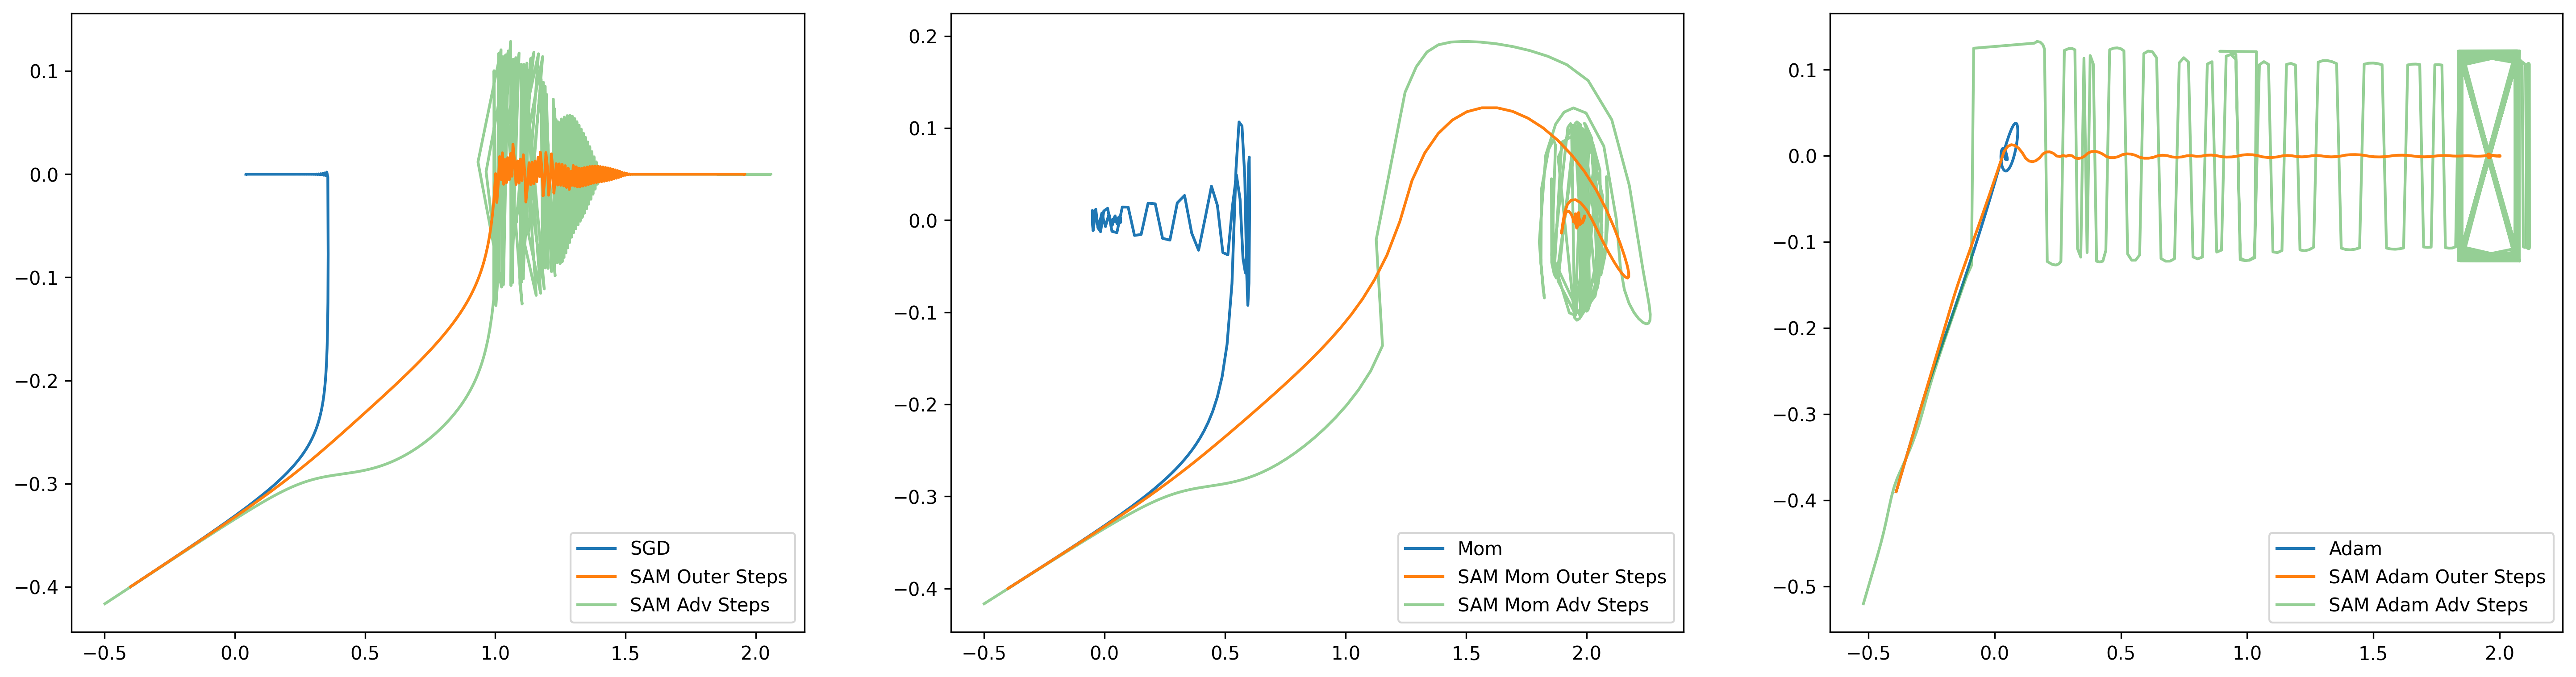

In [14]:
fig, axs = plt.subplots(ncols=3, figsize=(8 * 3, 6), dpi=300)
axs[0].plot(*jnp.array(sgd_params).T, label='SGD')
axs[0].plot(*jnp.array(sam_params)[1::2].T, label='SAM Outer Steps', zorder=100)
axs[0].plot(*jnp.array(sam_params)[::2].T, label='SAM Adv Steps', alpha=0.5)
axs[0].legend(loc=4);

axs[1].plot(*jnp.array(mom_params).T, label='Mom')
axs[1].plot(*jnp.array(sam_mom_params)[1::2].T, label='SAM Mom Outer Steps', zorder=100)
axs[1].plot(*jnp.array(sam_mom_params)[::2].T, label='SAM Mom Adv Steps', alpha=0.5)
axs[1].legend(loc=4);

axs[2].plot(*jnp.array(adam_params).T, label='Adam')
axs[2].plot(*jnp.array(sam_adam_params)[4::5].T, label='SAM Adam Outer Steps', zorder=100)
axs[2].plot(*jnp.array(sam_adam_params)[3::5].T, label='SAM Adam Adv Steps', alpha=0.5)
axs[2].legend(loc=4);